# Fast Personalized Pagerank Implementation (Moler PageRank)
I needed a fast PageRank for Wikisim project, it has to be fast enough that can run in real time on relatively small graphs. I started from optimizing the networkx, however, I found a very nice algorithm by **Cleve Mole** which takes the full advantage of sparse matrix operations. 
I implemented two versions of the algorithm in Python, both inspired  by the sparse fast solutions given in [**Cleve Moler**](https://en.wikipedia.org/wiki/Cleve_Moler)'s book, [*Experiments with MATLAB*](http://www.mathworks.com/moler/index_ncm.html). The power method is much faster with enough precision for our task. Our benchmarsk shows that this implementation is **faster than both Networkx and iGraph** implementationa magnititude of times.

## Personalized Pagerank
I modified the algorithm a little bit to be able to calculate **personalized Pagerank** as well. 

## Input Format
The input is a 2d array, each row of the array is an edge of the graph $[[a,b], [c,d]]$, $a$ and $b$ are the node numbers. The **personalization vector** is probability distribution over the nodes, a.k.a **teleporting vector**.

## Comparison with Popular Python Implementations: Networkx and iGraph
Both of the implementation (Exact Solution and PowerMethod) are much faster than their correspondent method in NetworkX. 

#

In [11]:
!pip install flake8 pycodestyle pycodestyle_magic

    100% |████████████████████████████████| 71kB 233kB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 30.4MB/s ta 0:00:01
flake8 3.7.7 has requirement pycodestyle<2.6.0,>=2.5.0, but you'll have pycodestyle 2.4.0 which is incompatible.
  Found existing installation: pyflakes 1.6.0
    Uninstalling pyflakes-1.6.0:
      Successfully uninstalled pyflakes-1.6.0
  Found existing installation: entrypoints 0.2.3
Cannot uninstall 'entrypoints'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
%load_ext pycodestyle_magic

ModuleNotFoundError: No module named 'pycodestyle_magic'

In [ ]:
%%writefile ../src/pagerank.py
"""Two "fast" implementations of PageRank.

Pythom implementations of Matlab original in Cleve Moler, Experiments with MATLAB.
"""
# uncomment
from __future__ import division

import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg 


__author__ = "Armin Sajadi"
__copyright__ = "Copyright 215, The Wikisim Project"
__credits__ = ["Armin Sajadi"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Armin Sajadi"
__email__ = "sajadi@cs.dal.ca"
__status__ = "Development"



def moler_pagerank_sparse(G, p=damping_factor, personalize=None, reverse=False):
    """ Calculates pagerank given a csr graph
    
    Inputs:
    -------
    
    G: a csr graph.
    p: damping factor
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions. It will be normalized automatically
    reverse: If true, returns the reversed-pagerank 
        
    outputs
    -------
    
    Pagerank Scores for the nodes
     
    """
    # In Moler's algorithm, $G_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if not reverse: 
        G=G.T;

    n,n=G.shape
    c=sp.asarray(G.sum(axis=0)).reshape(-1)
    r=sp.asarray(G.sum(axis=1)).reshape(-1)

    k=c.nonzero()[0]

    D=sprs.csr_matrix((1/c[k],(k,k)),shape=(n,n))

    if personalize is None:
        personalize=sp.ones(n) 
    personalize=personalize.reshape(n,1)
    e=(personalize/personalize.sum())*n 

    I=sprs.eye(n)
    x = sprs.linalg.spsolve((I - p*G.dot(D)), e);

    x=x/x.sum()
    return x
def moler_pagerank_sparse_power(G, p=damping_factor, max_iter = 100,  tol=1e-06,personalize=None, reverse=False):
    """ Calculates pagerank given a csr graph
    
    Inputs:
    -------
    G: a csr graph.
    p: damping factor
    max_iter: maximum number of iterations
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions. It will be normalized automatically
    reverse: If true, returns the reversed-pagerank 
        
    Returns:
    --------
    Pagerank Scores for the nodes
     
    """
    # In Moler's algorithm, $G_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if not reverse: 
        G=G.T;

    n,n=G.shape
    c=sp.asarray(G.sum(axis=0)).reshape(-1)
    r=sp.asarray(G.sum(axis=1)).reshape(-1)

    k=c.nonzero()[0]

    D=sprs.csr_matrix((1/c[k],(k,k)),shape=(n,n))

    if personalize is None:
        personalize=sp.ones(n) 
    personalize=personalize.reshape(n,1)
    e=(personalize/personalize.sum())*n 
    
    
    z = (((1-p)*(c!=0) + (c==0))/n)[sp.newaxis,:]
    G = p*G.dot(D)
    
    x = e/n 
    oldx = sp.zeros((n,1));
    
    iteration = 0
    
    while sp.linalg.norm(x-oldx) > tol:
        oldx = x
        x = G.dot(x) + e.dot(z.dot(x))
        iteration += 1
        if iteration >= max_iter:
            break;
    x = x/sum(x)
    
    return x.reshape(-1)

# Testing the algorithm

In [ ]:
!pip install python-igraph

In [7]:
%%writefile ../test/pagerank_test.py

import networkx as nx
import random
import timeit
import numpy as np
import igraph
from numpy.testing import assert_array_almost_equal

import os, sys
current = os.path.dirname(os.path.realpath(__file__))
src_path = os.path.join(current, '..')
sys.path.insert(0,src_path)

from src.pagerank import *

def get_random_graph(min_size=100, max_size=300, min_sparsity = 0.1, max_sparsity = 0.5):
    ''' Creates a random graph and a teleport vector and output them in different formats for different algorithms
    
    Inputs
    ------
    
    min_size and max_size: The size of the graph will be a random number in the range of (min_size, max_size)
    min_sparsity and max_sparsity: The sparcity of the graph will be a random number in the range of (min_sparsity, max_sparsity)
    
    Returns
    -------
    
    nxG: A random Graph for NetworkX
    A: The equivallent csr Adjacency matrix, for our moler_pagerank
    iG: The equivallent iGraph
    customization_vector: Personalization probabily vector
    customization_dict: Personalization probabily vector, in the form of a dictionary for NetworkX
    
    '''
    passed=True
    G_size = random.randint(min_size,max_size)
    p=random.uniform(min_sparsity, max_sparsity)
    nxG = nx.fast_gnp_random_graph(G_size, p, seed=None, directed=True)
    for e in nxG.edges():
         nxG[e[0]][e[1]]['weight']=sp.rand()

    A=nx.to_scipy_sparse_matrix(nxG)

    iG=igraph.Graph(list(nxG.edges()), directed=True)
    iG.es['weight'] = A.data
    
    customization_vector = np.random.random(G_size)
    customization_dict = dict(enumerate(customization_vector.reshape(-1)))
    return nxG, A, iG, customization_vector, customization_dict

import unittest

class TestMolerPageRank(unittest.TestCase):
    def setUp(self):
        self.number_of_tests = 10
    def test_exact_pagerank(self):
        damping_factor = 0.85
        for i in range(self.number_of_tests):
            nxG, A, iG, customization_vector, customization_dict = get_random_graph()

            Xnx  = nx.pagerank_numpy(nxG, alpha=damping_factor, personalization = customization_dict) 
            Xnx =  np.array([v for k,v in Xnx.items() ])

            Xml =  moler_pagerank_sparse(A, p=damping_factor, personalize=customization_vector)

            assert_array_almost_equal(Xnx,  Xml, decimal = 5)
        
    def test_power_pagerank(self):
        damping_factor = 0.85
        tol = 1e-06
        for i in range(self.number_of_tests):
            nxG, A, iG, customization_vector, customization_dict = get_random_graph()

            Ynx =  nx.pagerank_scipy(nxG, alpha=damping_factor, tol=tol, personalization=customization_dict)
            Ynx =  np.array([v for k,v in Ynx.items() ])

            Yml =  moler_pagerank_sparse_power(A, p=damping_factor, tol=tol, personalize=customization_vector)


            assert_array_almost_equal(Ynx,  Yml, decimal = 5)
            
if __name__ == '__main__':
    unittest.main()

Overwriting ../test/pagerank_test.py


In [8]:
!python  ../test/pagerank_test.py

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
..
----------------------------------------------------------------------
Ran 2 tests in 2.488s

OK


# Benchmarking

To avoid the clutter, we only visualize the fastest method from each implementation, that is: 
.

In [9]:
import networkx as nx
import random
import timeit
import sys
sys.path.insert(0,'..')

from test.pagerank_test import *

n=5
number_of_graphs=20

size_vector=sp.zeros(number_of_graphs)
netx_pagerank=sp.zeros(number_of_graphs)
netx_pagerank_numpy=sp.zeros(number_of_graphs)
netx_pagerank_scipy=sp.zeros(number_of_graphs)
moler_pagerank=sp.zeros(number_of_graphs)
moler_pagerank_power=sp.zeros(number_of_graphs)
ig_pagerank = sp.zeros(number_of_graphs)

damping_factor = 0.85
tol = 1e-3


for i in range(number_of_graphs):
    nxG, A, iG, customization_vector, customization_dict = get_random_graph(min_size=100, max_size=1000)
    size_vector[i] = nxG.number_of_edges()

    netx_pagerank[i] = timeit.timeit(lambda: nx.pagerank(nxG, alpha=damping_factor, tol=tol), number=n)/n
    netx_pagerank_numpy[i] = timeit.timeit(lambda: nx.pagerank_numpy(nxG, alpha=damping_factor), number=n)/n
    netx_pagerank_scipy[i] = timeit.timeit(lambda: nx.pagerank_scipy(nxG, alpha=damping_factor, tol=tol), number=n)/n
    
    ig_pagerank[i] = timeit.timeit(lambda: iG.personalized_pagerank(directed=True, damping=damping_factor, weights=iG.es['weight'], implementation="prpack"), number=n)/n
    
    moler_pagerank[i] = timeit.timeit(lambda: moler_pagerank_sparse(A, p=damping_factor), number=n)/n
    moler_pagerank_power[i] = timeit.timeit(lambda: moler_pagerank_sparse_power(A, p=damping_factor, tol=tol), number=n)/n
    
    
argsort = size_vector.argsort()

size_vector_sorted = size_vector[argsort]

netx_pagerank_sorted = netx_pagerank[argsort]
netx_pagerank_numpy_sorted = netx_pagerank_numpy[argsort]
netx_pagerank_scipy_sorted = netx_pagerank_scipy[argsort]

moler_pagerank_sorted = moler_pagerank[argsort]
moler_pagerank_power_sorted = moler_pagerank_power[argsort]

ig_pagerank_sorted = ig_pagerank[argsort]


print ("Done")

Done


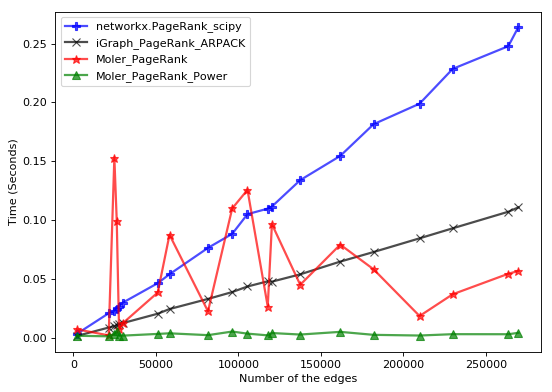

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')





#plt.plot(size_vector_sorted, netx_pagerank_sorted, 'o-',  ms=8, lw=2,alpha=0.7, color='cyan', label='networkx.PageRank')
#plt.plot(size_vector_sorted, netx_pagerank_numpy_sorted, 'v-', ms=8, lw=2,alpha=0.7, color='magenta', label='networkx.PageRank_numpy')
plt.plot(size_vector_sorted, netx_pagerank_scipy_sorted, 'P-', ms=8, lw=2,alpha=0.7, color='blue', label='networkx.PageRank_scipy')

plt.plot(size_vector_sorted, ig_pagerank_sorted, 'x-', ms=8, lw=2,alpha=0.7, color='black', label='iGraph_PageRank_ARPACK')

plt.plot(size_vector_sorted, moler_pagerank, '*-', ms=8, lw=2,alpha=0.7, color='red', label='Moler_PageRank')
plt.plot(size_vector_sorted, moler_pagerank_power, '^-', ms=8, lw=2,alpha=0.7, color='green', label='Moler_PageRank_Power')


plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank_exact.eps')
plt.show()


# Comparing Approximation Methods (Power Methods)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')

argsort = size_vector.argsort()

size_vector_sorted = size_vector[argsort]
netx_pagerank_scipy_sorted = netx_pagerank_scipy[argsort]
moler_pagerank_power_sorted = moler_pagerank_power[argsort]



plt.plot(size_vector_sorted, netx_pagerank_scipy_sorted, 'P-', ms=8, lw=2,alpha=0.7, color='black', label='networkx.PageRank_scipy')
plt.plot(size_vector_sorted, moler_pagerank_power, '^-', ms=8, lw=2,alpha=0.7, color='green', label='Moler_PageRank_Power')
#plt.plot(size_vector_sorted, ig_pagerank, '^-', ms=8, lw=2,alpha=0.7, color='red', label='Moler_PageRank_Power')

plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank.eps')
plt.show()
